In [1]:
import cuentitas
from cuentitas import a0VV, a1VVF1, a1VVF2

from auxiliares import integracionGauss as ig
from auxiliares import medicion
from auxiliares import S0VV_completo

from numpy import pi, sqrt, sin, cos, exp, log10, array, real, conj
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy import interpolate
import seaborn as sns
import pandas as pd

import theano.tensor as TT
import time
import random

import pymc3 as pm

sns.set() #seaborn como default

m = 51 #valores que siempre uso
X,Y,Wt = ig(m-1)

In [2]:
def toFit(ep1,ep2,d,s1,l1,s2,l2,angulo):
    landa = 0.025
    k0 = 2*np.pi/landa
    phi = np.pi
    
    ### s0
    phs = phi + np.pi
    thi = angulo  #cambiar segun la zona
    thi = thi*np.pi/180 #DU2 T008, T061, T021
    ths = thi
    k1 = k0*(sin(ths)*cos(phs)-sin(thi)*cos(phi))
    k2 = k0*(sin(ths)*sin(phs)-sin(thi)*sin(phi))
 
    aux = 4*np.pi*k0**2*cos(ths)**2*(abs(cuentitas.a1VVF1(k0,thi,phi,ths,phs,ep1,ep2,d))**2*cuentitas.w(s1,l1,k1,k2)+\
            abs(cuentitas.a1VVF2(k0,thi,phi,ths,phs,ep1,ep2,d))**2*cuentitas.w(s2,l2,k1,k2)+\
            2*real(cuentitas.a1VVF1(k0,thi,phi,ths,phs,ep1,ep2,d)*conj(cuentitas.a1VVF2(k0,thi,phi,ths,phs,ep1,ep2,d)))*cuentitas.w_f1f2(s1,l1,s2,l2,k1,k2))
    s0s = 10*np.log10(aux)
    
    ### emi
    thi = 0.0001*np.pi/180
    
    ths_ = (X+1)*np.pi/4
    phs_ = (Y+1)*np.pi
    
    ths_1 = np.reshape(ths_, (1,m**2))
    phs_1 = np.reshape(phs_, (1,m**2))
    
    q = (np.sin(ths_1)*S0VV_completo(k0,thi,phi,ths_1,phs_1,ep1,ep2,d,s1,l1,s2,l2))
    aux = Wt*q
    I_gauss = (np.pi**2/4)*aux.sum()
 
    emi = 1 - (I_gauss/(4*np.pi))
 
    a = TT.zeros(4)
    aa = TT.set_subtensor(a[0], s0s[0])
    aaa = TT.set_subtensor(aa[1], s0s[1])
    aaaa = TT.set_subtensor(aaa[2], s0s[2])
    aaaaa = TT.set_subtensor(aaaa[3], emi)
 
    return aaaaa

In [15]:
def modelo(sector, samples, sigmas):
 
    landa = 0.025
    k0 = 2*np.pi/landa
    phi = np.pi
 
    ranges = {}
    ranges['ep1'] = 1.4, 8
    ranges['ep2'] = 1.4, 8
    ranges['d'] = 0.001, 0.8
    ranges['s1'] = 0.0004, 0.004
    ranges['l1'] = 0.005, 0.03
    ranges['s2'] = 0.0004, 0.004
    ranges['l2'] = 0.005, 0.03
 
    with pm.Model() as model:
        ep1 = pm.Uniform('ep1', ranges['ep1'][0], ranges['ep1'][1])
        ep2 = pm.Uniform('ep2', ranges['ep2'][0], ranges['ep2'][1])
        d = pm.Uniform('d', ranges['d'][0], ranges['d'][1])
        s1 = pm.Uniform('s1', ranges['s1'][0], ranges['s1'][1])
        l1 = pm.Uniform('l1', ranges['l1'][0], ranges['l1'][1])
        s2 = pm.Uniform('s2', ranges['s2'][0], ranges['s2'][1])
        l2 = pm.Uniform('l2', ranges['l2'][0], ranges['l2'][1])

#impongo l1 = 10*s1 y lo mismo en 2, hipotesis fuerte

    def f(ep1 = ep1, 
          ep2 = ep2, 
          d = d, 
          s1 = s1, 
          l1 = l1,
          s2 = s2, 
          l2 = l2
         ):
        return toFit(ep1,ep2,d,s1,l1,s2,l2,sector[0])
 
    with model:
        # s1 = pm.Normal('s1_mu',s1,1)
        # l1 = pm.Normal('l1_mu',l1, 0.005)
        # s2 = pm.Normal('s2_mu',s2, 0.0005)
        function_pm = pm.Deterministic('s0f', f())
        observations = pm.Normal( "obs",  mu=real(function_pm), sigma=sigmas, observed=sector[1])
        trace = pm.sample_smc(samples, cores=4, parallel=True)
    
    return trace
    

In [22]:
def modelo_hs(sector, samples, sigmas):
 
    landa = 0.025
    k0 = 2*np.pi/landa
    phi = np.pi
 
    ranges = {}
    ranges['ep1'] = 1.4, 8
    ranges['ep2'] = 1.4, 8
    ranges['d'] = 0.001, 0.8
    ranges['s1'] = 0.0004, 0.004
    ranges['l1'] = 0.005, 0.03
    ranges['s2'] = 0.0004, 0.004
    ranges['l2'] = 0.005, 0.03
 
    with pm.Model() as model:
        ep1 = pm.Uniform('ep1', ranges['ep1'][0], ranges['ep1'][1])
        ep2 = pm.Uniform('ep2', ranges['ep2'][0], ranges['ep2'][1])
        d = pm.Uniform('d', ranges['d'][0], ranges['d'][1])
        s1 = pm.Uniform('s1', ranges['s1'][0], ranges['s1'][1])
        l1 = pm.Uniform('l1', ranges['l1'][0], ranges['l1'][1])
        s2 = pm.Uniform('s2', ranges['s2'][0], ranges['s1'][1])
        l2 = pm.Uniform('l2', ranges['l2'][0], ranges['l2'][1])

#impongo l1 = 10*s1 y lo mismo en 2, hipotesis fuerte

    def f(ep1 = ep1, 
          ep2 = ep2, 
          d = d, 
          s1 = s1, 
          l1 = l1,
          s2 = s2, 
          l2 = l2
         ):
        return toFit(ep1,ep2,d,s1,l1,s2,l2,sector[0])
 
    with model:
        s1 = pm.Normal('s1_mu',s1,0.0005)
        l1 = pm.Normal('l1_mu',l1, 0.005)
        s2 = pm.Normal('s2_mu',s2, 0.0005)
        function_pm = pm.Deterministic('s0f', f())
        observations = pm.Normal( "obs",  mu=real(function_pm), sigma=sigmas, observed=sector[1])
        trace = pm.sample_smc(samples, cores=4, parallel=True)
    
    return trace

In [23]:
t0 = time.time()

zonaMed = 'HU2'
muestras = 5000
sigmas = np.asarray([1.5, 1.5, 1.5, 0.05])

traza = modelo_hs(medicion(zonaMed),muestras,sigmas)

Initializing SMC sampler...
Sampling 4 chains in 4 jobs
WARNING (theano.tensor.opt): Optimization Warning: The Op exp does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): Optimization Warning: The Op true_div does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): Optimization Warning: The Op exp does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): Optimization Warning: The Op true_div does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): Optimization Warning: The Op exp does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): Optimization Warning: The Op true_div does not provide a C implementation. 

In [6]:
e1 = traza['ep1']
e2 = traza['ep2']
d = traza['d']
s1 = traza['s1']
l1 = traza['l1']
s2 = traza['s2']
l2 = traza['l2']

guardar = [e1,e2,d,s1,l1,s2,l2]

# f = np.savetxt('Datos2/'+zonaMed+'-M='+str(muestras)+'e='+str(sigmas[0])+'.txt', guardar, delimiter=';')
print('Archivo guardado')

Archivo guardado


Ploteando...
tiempo:537.9390988349915seg (0.1494275274541643hs)


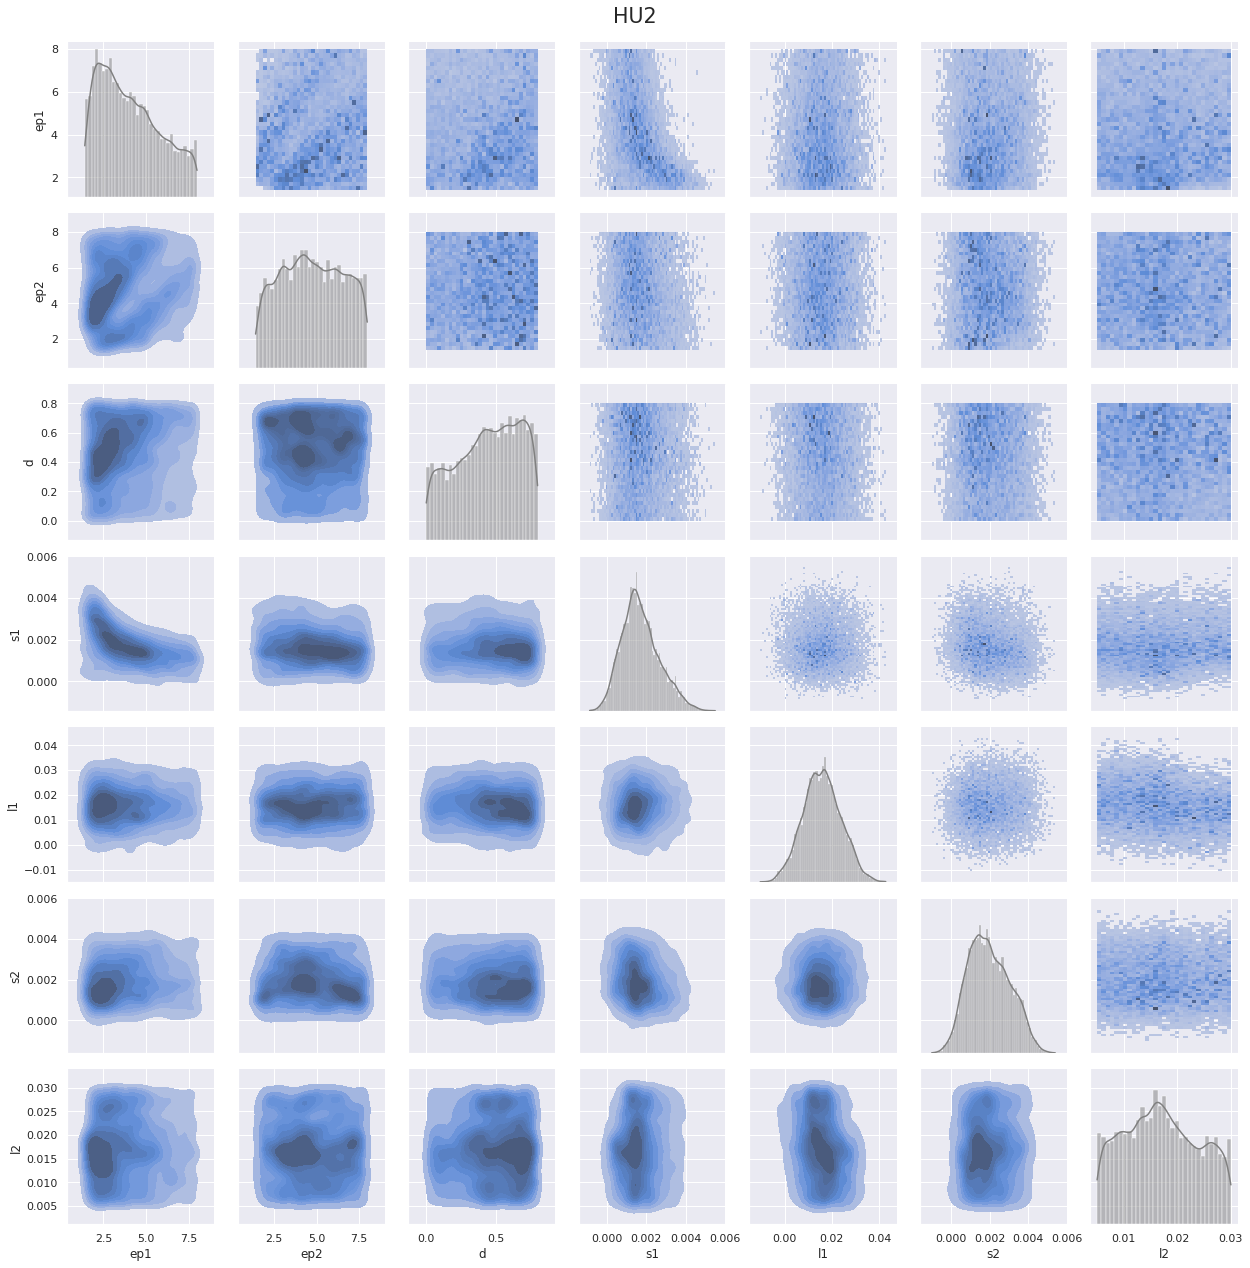

In [24]:
#Ploteo
print('Ploteando...')

# plotear = np.stack((traza['ep1'], traza['ep2'], traza['d'], traza['s1'], traza['s2'])).T 
# dfplotear = pd.DataFrame(plotear, columns = ['ep1','ep2','d','s1','s2'])

plotear = np.stack((traza['ep1'], traza['ep2'], traza['d'], traza['s1_mu'], traza['l1_mu'], traza['s2_mu'], traza['l2'])).T 
dfplotear = pd.DataFrame(plotear, columns = ['ep1','ep2','d','s1','l1','s2','l2'])

g = sns.PairGrid(dfplotear)
g.fig.suptitle(zonaMed, y=1.01, fontsize = 'xx-large')
g.map_upper(sns.histplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True, color='.5')
# g.savefig('Datos2/'+zonaMed+'-M='+str(muestras)+'e='+str(sigmas[0])+'.png')

t1 = time.time()
print('tiempo:'+str(t1-t0)+'seg', '('+str((t1-t0)/3600)+'hs)')
#files.download('prueba.png') #descarga la imagen

In [9]:
# g.savefig('Datos2/'+zonaMed+'-M='+str(muestras)+'e='+str(sigmas[0])+'-7parametros.png')